# 03. Pytorch Machine Vision Class

In [2]:
import requests
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from torchmetrics import Accuracy, ConfusionMatrix
import mlxtend
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix
import random
from pathlib import Path

c:\Users\Tiger\anaconda3\envs\py311Udemy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [137]:
# Import torch
# import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## get data set

In [ ]:
# # set up trainng dta
train_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None

    )
# set up test dta
test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None

    )

In [139]:
print(len (train_data), len(test_data))
image, label = train_data[0]
print (image, label)
print (train_data.classes)
print (train_data.class_to_idx)

60000 10000
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0

In [140]:
print(image.shape)
print (train_data.classes[label])

torch.Size([1, 28, 28])
Ankle boot


## visualize

Text(0.5, 1.0, '9')

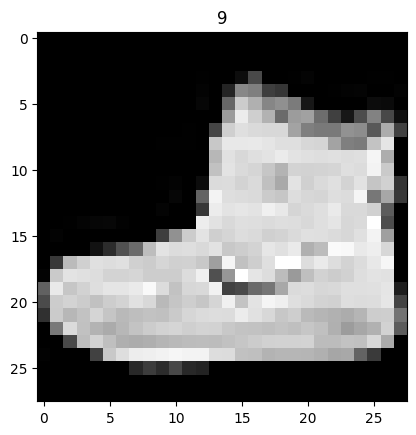

In [141]:
plt.imshow(image.squeeze(), cmap="grey")
plt.title(label)

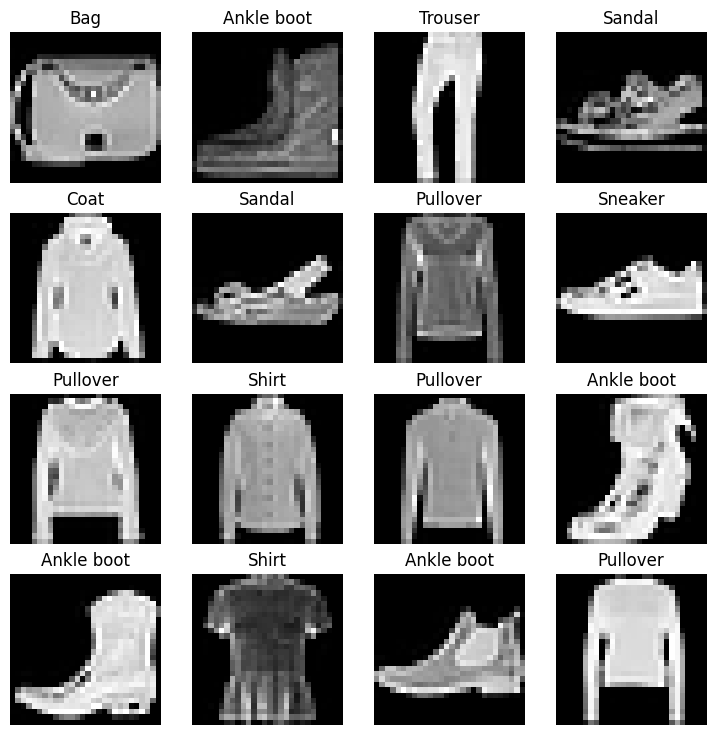

In [142]:
# Show 16 pictures
fig = plt.figure (figsize=(9,9))
rows, cols = 4, 4
for i in range (1, rows*cols + 1):
    img_index = torch.randint(0, len(train_data), size = [1]).item()
    fig.add_subplot (rows, cols, i)
    img, lbl = train_data[img_index]
    plt.imshow(img.squeeze(), cmap = 'grey')
    plt.title(train_data.classes[lbl])
    plt.axis(False)


In [143]:
# turn data into iterable 

In [144]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
print(train_dataloader, test_dataloader)
print (len(train_dataloader), BATCH_SIZE)
print (len (test_dataloader), BATCH_SIZE)


<torch.utils.data.dataloader.DataLoader object at 0x00000273CE5B9D50> <torch.utils.data.dataloader.DataLoader object at 0x0000027452829B50>
1875 32
313 32


In [145]:
# show each batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

torch.Size([1, 28, 28])
tensor(1) torch.Size([])


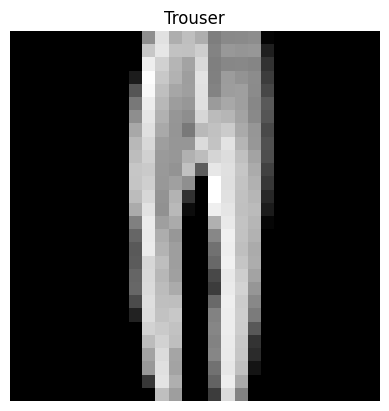

In [146]:
# show sample of 
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'grey')
plt.title (train_data.classes[label])
plt.axis(False)
print (img.shape)
print (label, label.shape)

## Baseline Model

In [147]:
# flatten data
flatten_data = nn.Flatten()
x_0 = train_features_batch[0]
x_0_flatten = flatten_data(x_0)
x_0.shape, x_0_flatten.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [148]:
# first model
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int = 784,
                 hidden_units: int = 256,
                 output_shape: int =10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [149]:
# set model
torch.manual_seed(42)
model_0 = FashionMNISTModelV0()
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [150]:
dummy_x = torch.rand([1,1, 28, 28])
model_0(dummy_x)


tensor([[-0.1632,  0.1134, -0.0667,  0.3176,  0.0384, -0.0599,  0.1459, -0.1255,
          0.1022,  0.2317]], grad_fn=<AddmmBackward0>)

In [151]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [ 0.0307,  0.0202,  0.0212,  ...,  0.0272,  0.0314,  0.0152],
                      [-0.0355,  0.0334, -0.0232,  ...,  0.0185, -0.0292, -0.0017],
                      [-0.0068, -0.0321,  0.0248,  ..., -0.0255, -0.0138, -0.0288]])),
             ('layer_stack.1.bias',
              tensor([ 0.0214, -0.0092,  0.0252,  0.0054, -0.0258, -0.0166, -0.0220, -0.0342,
                      -0.0085,  0.0256, -0.0313, -0.0035,  0.0126,  0.0164,  0.0323, -0.0243,
                       0.0015,  0.0066,  0.0342, -0.0187,  0.0285,  0.0317,  0.0150,  0.0209,
                      -0.0146,  0.0140,  0.0086,  0.0305, -0.0045,  0.0026,  0.0236, -0.0042,
                

In [152]:
# loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                                                      lr = 0.1)


In [153]:
# time functions
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print (f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [154]:
start_time = timer() 
end_time = timer ()

print_train_time(start_time, end_time, device = 'cpu')

Train time on cpu: 0.000 seconds


3.139988984912634e-05

## use data loader for training


In [155]:
# loop for batch
torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
        model_0.train()
        y_pred = model_0(X)

        loss = loss_fn (y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 ==0:
            print (f'Batch Number  {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0 (X_test)
            test_loss  += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true = y_test, y_pred=test_pred.argmax(dim = 1)) 

        test_loss /= len(test_dataloader)
        test_acc /= len (test_dataloader)

    print (f"\nTrain loss: {train_loss:.4f}| test loss: {test_loss:.4f} , Test acc {test_acc:4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start= train_time_start_on_cpu, 
                                            end = train_time_end_on_cpu,
                                            device = str(next (model_0.parameters()).device))








Epoch 0

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples



Train loss: 0.5748| test loss: 0.5027 , Test acc 82.517971
Epoch 1

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples



Train loss: 0.4739| test loss: 0.4838 , Test acc 82.857428
Epoch 2

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


100%|██████████| 3/3 [00:29<00:00,  9.96s/it]


Train loss: 0.4539| test loss: 0.4763 , Test acc 83.506390
Train time on cpu: 29.879 seconds


In [156]:
# import torch.utils
# import torch.utils.data


torch.manual_seed(42)
def eval_model (model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn):
    loss, acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model (X)

            loss += loss_fn (y_pred, y)
            acc += accuracy_fn(y_true = y,
                                y_pred = y_pred.argmax(dim= 1))
        loss /= len (data_loader)
        acc /= len(data_loader)

    return {"mode_name": model.__class__.__name__,
            "model_loss": loss.item(),
            'model_acc': acc}

model_0_results = eval_model(model = model_0, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results


    
    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Non Linear model with GPU

In [ ]:
# first model
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int = 784,
                 hidden_units: int = 256,
                 output_shape: int =10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
model_1 = FashionMNISTModelV1().to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                                                      lr = 0.1)


In [ ]:
# loop for batch
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loss = 0
    for batch, (X, y) in enumerate (train_dataloader):
        model_1.train()
        X, y = X.to(device), y.to(device)
        y_pred = model_1(X)

        loss = loss_fn (y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 ==0:
            print (f'Batch Number  {batch * len(X)}/{len(train_dataloader.dataset)} samples')

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model_1 (X_test)
            test_loss  += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true = y_test, y_pred=test_pred.argmax(dim = 1)) 

        test_loss /= len(test_dataloader)
        test_acc /= len (test_dataloader)

    print (f"\nTrain loss: {train_loss:.4f}| test loss: {test_loss:.4f} , Test acc {test_acc:4f}")

train_time_end_on_cpu = timer()
total_train_time_model_1 = print_train_time(start= train_time_start_on_cpu, 
                                            end = train_time_end_on_cpu,
                                            device = str(next (model_1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


 33%|███▎      | 1/3 [00:10<00:20, 10.44s/it]


Train loss: 0.5567| test loss: 0.4444 , Test acc 83.955671
Epoch 1

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


 67%|██████▋   | 2/3 [00:22<00:11, 11.23s/it]


Train loss: 0.4021| test loss: 0.4044 , Test acc 85.293530
Epoch 2

Batch Number  0/60000 samples
Batch Number  12800/60000 samples
Batch Number  25600/60000 samples
Batch Number  38400/60000 samples
Batch Number  51200/60000 samples


100%|██████████| 3/3 [00:33<00:00, 11.19s/it]


Train loss: 0.3620| test loss: 0.3783 , Test acc 86.261981
Train time on cuda:0: 33.572 seconds


In [ ]:
# evaluate model 1
model_1_results = eval_model(model = model_1, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

{'mode_name': 'FashionMNISTModelV1',
 'model_loss': 0.37831225991249084,
 'model_acc': 86.26198083067092}

## Functionalze train and test loop


In [ ]:
import torch.utils


def train_loop(model: nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device= device
              ):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_train_pred = model(X)
        loss = loss_fn(y_train_pred, y)
        train_loss += loss
        train_acc  += accuracy_fn(y_true = y, 
                                  y_pred = y_train_pred.argmax (dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print (f'Train loss: {train_loss:.4f}| Train accuracy: {train_acc:.2f}%')
    

def test_loop (model: nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device = device):
    test_loss = 0
    test_acc = 0
    model.eval ()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_test_pred = model(X)
        test_loss += loss_fn(y_test_pred, y)
        test_acc += accuracy_fn(y_true = y,
                                y_pred = y_test_pred.argmax(dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print (f'Train loss: {test_loss:.5f}| Train Acc {test_acc:.2f}%')    

## call functions to do model 1

In [ ]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loop(model=model_1,
               dataloader=train_dataloader,
               loss_fn =loss_fn,
               optimizer = optimizer,
               accuracy_fn=accuracy_fn,
               device = device)
    
    test_loop (model=model_1,
               dataloader= test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn = accuracy_fn,
               device = device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

Train loss: 0.3362| Train accuracy: 87.79%


 33%|███▎      | 1/3 [00:12<00:24, 12.23s/it]

Train loss: 0.36559| Train Acc 86.72%
Epoch 1

Train loss: 0.3183| Train accuracy: 88.37%


 67%|██████▋   | 2/3 [00:24<00:12, 12.08s/it]

Train loss: 0.35530| Train Acc 87.20%
Epoch 2

Train loss: 0.3032| Train accuracy: 88.81%


100%|██████████| 3/3 [00:36<00:00, 12.26s/it]

Train loss: 0.34618| Train Acc 87.43%
Train time on cuda: 36.785 seconds


## test the manual

In [ ]:
# evaluate model 1
model_1_results = eval_model(model = model_1, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

{'mode_name': 'FashionMNISTModelV1',
 'model_loss': 0.34618425369262695,
 'model_acc': 87.43011182108626}

## Conv Neural Networks

In [229]:
# create CNN with Tiny VGG
class FashionMNISTModelV2(nn.Module):

    def __init__(self, 
                input_shape: int, 
                hidden_units:int, 
                output_shape: int):
        super().__init__()
        self.block_1= nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)            
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features = hidden_units*7*7,
                    out_features=output_shape)

        )

    def forward(self, x):
        x = self.block_1(x)
        # print (x.shape)
        x=self.block_2(x)
        # flat_x = x.view (x.size(0), -1)
        # self._flat_size = flat_x.size(1)
        x = self.classifier(x)
        # print (x.shape)
        return x


        



In [230]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len (train_data.classes)).to(device)

### Conv 2d test code

In [231]:
torch.manual_seed(42)

images = torch.randn(size = (32, 3, 64, 64))
test_image = images [0]
print (images.shape)
print(test_image.shape)

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


In [232]:
# creates single conv2d
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size = 3,
                       stride=1,
                       padding=0)

conv_output = conv_layer (test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

In [233]:
# test max pool
print(test_image.shape)
print (test_image.unsqueeze(0).shape)

max_pool_layer = nn.MaxPool2d(kernel_size=2)

# go through conv layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print (test_image_through_conv.shape)

# go through maxpool layer
test_image_throught_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(test_image_throught_conv_and_max_pool.shape)



torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 62, 62])
torch.Size([1, 10, 31, 31])


In [234]:
# try with smaller tesnon
torch.manual_seed(42)
random_tensor = torch.randn(size = (1, 1, 2, 2))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_tensor = max_pool_layer (random_tensor)
print (random_tensor.shape)
print (max_pool_tensor.shape)

torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 1, 1])


## set up loss function and eval and optimzie

In [235]:
#  code for above
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params=model_2.parameters(), lr = 0.1)

In [236]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

from timeit import default_timer as timer
train_time_start_on_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print (f"Epoch {epoch}\n")
    train_loop(model=model_2,
               dataloader=train_dataloader,
               loss_fn =loss_fn,
               optimizer = optimizer,
               accuracy_fn=accuracy_fn)
    
    test_loop (model=model_2,
               dataloader= test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn = accuracy_fn)

train_time_end_on_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_model_2,
                                            end=train_time_end_on_model_2,
                                            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

Train loss: 0.5926| Train accuracy: 78.44%


 33%|███▎      | 1/3 [00:16<00:33, 16.97s/it]

Train loss: 0.40225| Train Acc 85.63%
Epoch 1

Train loss: 0.3603| Train accuracy: 86.98%


 67%|██████▋   | 2/3 [00:33<00:16, 16.65s/it]

Train loss: 0.35899| Train Acc 87.32%
Epoch 2

Train loss: 0.3224| Train accuracy: 88.25%


100%|██████████| 3/3 [00:49<00:00, 16.57s/it]

Train loss: 0.32024| Train Acc 88.58%
Train time on cuda: 49.707 seconds


In [237]:
# evaluate model 2
# evaluate model 1
model_2_results = eval_model(model = model_2, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_2_results

{'mode_name': 'FashionMNISTModelV2',
 'model_loss': 0.3202410638332367,
 'model_acc': 88.57827476038338}

In [238]:
# compare results.
# model_0_results = eval_model(model = model_0, 
#                              data_loader = test_dataloader,
#                              loss_fn = loss_fn,
#                              accuracy_fn=accuracy_fn)
# model_0_results
df_compare = pd.DataFrame([model_1_results, model_2_results])
df_compare['training_time'] = [total_train_time_model_1, total_train_time_model_2]
df_compare


,mode_name,model_loss,model_acc,training_time
0,FashionMNISTModelV1,0.346184,87.430112,36.784527
1,FashionMNISTModelV2,0.320241,88.578275,49.707001


Text(0, 0.5, 'model')

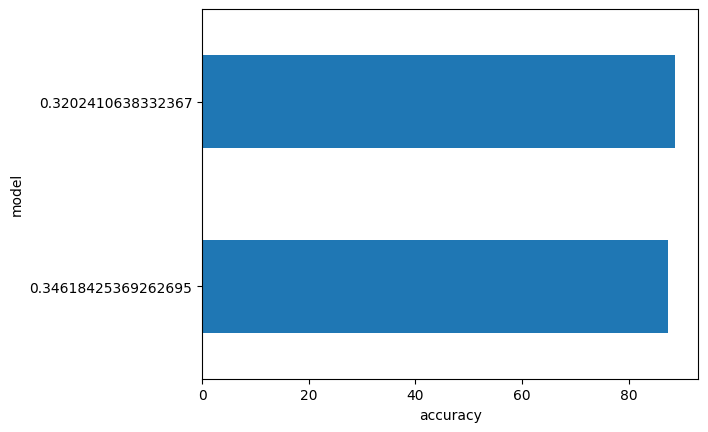

In [239]:
# visual
df_compare.set_index('model_loss')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy')
plt.ylabel('model')

In [240]:
img, label = test_data[1]
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0510, 0.2627, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1961, 0.1490, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314,
          0.4706, 0.8196, 0.8863, 0.9686, 0.9294, 1.0000, 1.0000, 1.0000,
          0.9686, 0.9333, 0.9216, 0.6745, 0.2824, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5373, 0.9373,
          0.9882, 0.9529, 0.9176, 0.8980, 0.9333, 0.9569, 0.9647, 0.9412,
          0.9020, 0.9098, 0.9373, 0.9725, 0.9843, 0.7608, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 1.0000, 0.9059,
          0.8941, 0.8902, 0.8941, 0.9137, 0.9020, 0.9020, 0.8980, 0.8941,
          0.9098, 0.9098, 0.9059, 0.8902, 0.8784, 0.9882,

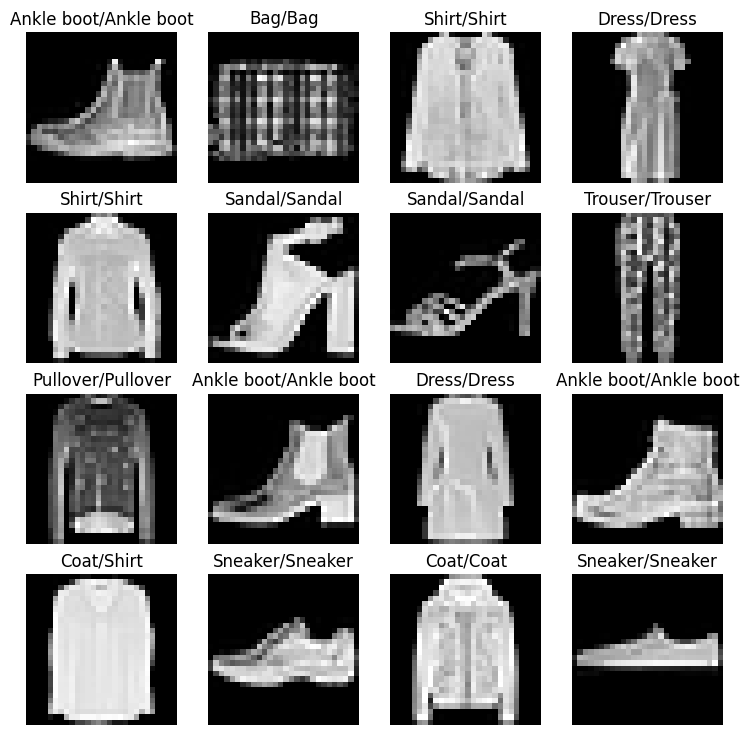

In [241]:
# select random samples and see prediction
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
class_names = train_data.classes
model_2.eval()
rows, cols = 4, 4
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        random_idx = torch.randint(0, len(test_data), size=[1]).item()
        img, label = test_data[random_idx]
        unsqz_img = torch.unsqueeze(img, dim = 0).to(device)
        pred_label = model_2(unsqz_img).argmax(dim=1)
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[label] + '/' +  class_names[pred_label] )
        plt.axis(False);

In [242]:
type(test_data[random_idx][1])

int

## code for prediction

In [243]:
# function
def make_predictions (model: torch.nn.Module,
                        data: list, 
                        device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)


In [244]:
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample (list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

print (test_samples[0].shape)
print (test_labels[0])
print (class_names[test_labels[0]])

torch.Size([1, 28, 28])
5
Sandal


In [245]:
# get probabilities and classes
pred_probs = make_predictions(model = model_2,
                            data=test_samples)
pred_classes = pred_probs.argmax(dim = 1)
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

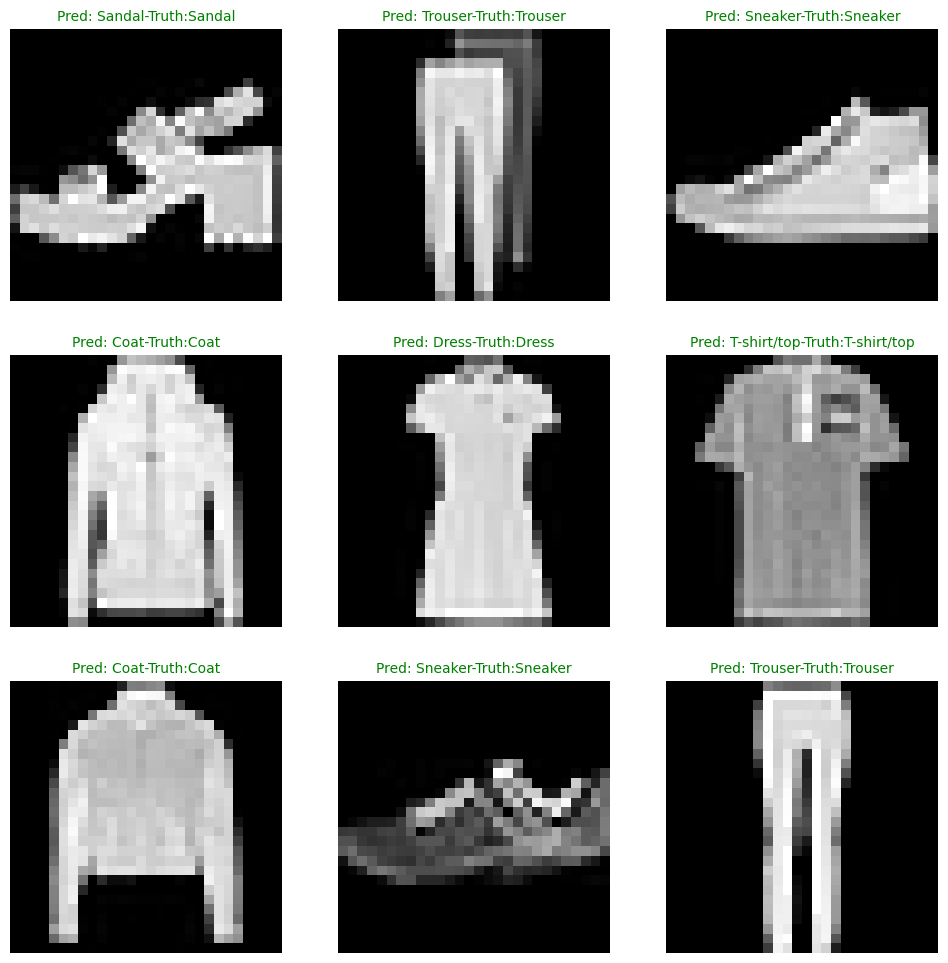

In [246]:
# plot predictions following tutorial code
nrows = 3
ncols =  3
plt.figure (figsize = (12, 12))
for i, sample in enumerate(test_samples):
    plt.subplot (nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap = 'gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f'Pred: {pred_label}-Truth:{truth_label}'

    if pred_label == truth_label:
        plt.title (title_text, fontsize = 10, c = 'g')
    else:
        plt.title(title_test, fontsize = 10, c= 'r')

    plt.axis(False)



## Make Confusion Matrix


In [247]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm (test_dataloader, desc = 'Making preditions'):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making preditions: 100%|██████████| 313/313 [00:01<00:00, 173.77it/s]


In [248]:
y_pred_tensor[:3]

tensor([9, 2, 1])

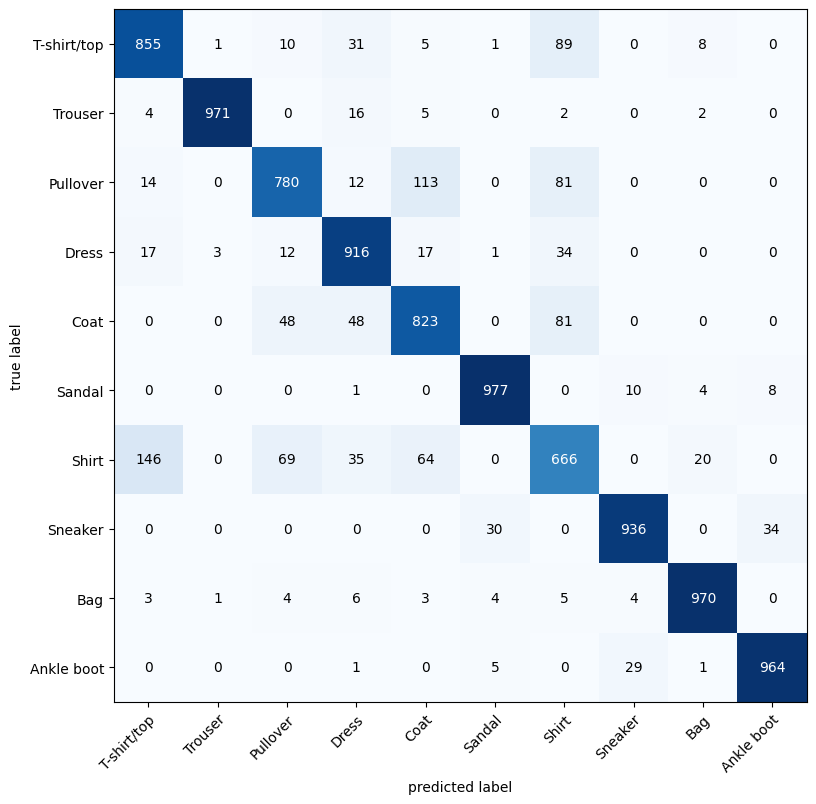

In [249]:
# set up confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, 
                        target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (12, 9)
)

## Save and load data

In [250]:
# save model
MODEL_PATH  = Path('models')
MODEL_PATH.mkdir (parents =True,
                    exist_ok=True)

MODEL_NAME = '03_pytorrch_computer_vision_model_2.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print (f'saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_2.state_dict(),
            f = MODEL_SAVE_PATH)


saving model to: models\03_pytorrch_computer_vision_model_2.pth


In [251]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.3313,  0.2924, -0.4610],
                        [ 0.1384,  0.1256,  0.0572],
                        [-0.3786,  0.1096,  0.4139]]],
              
              
                      [[[-0.3512,  0.3985, -0.0925],
                        [ 0.2118,  0.3576,  0.1516],
                        [-0.1486,  0.3453,  0.0892]]],
              
              
                      [[[-0.3147, -0.1259,  0.0432],
                        [-0.6458, -0.6685,  0.2032],
                        [-0.7452, -0.6224, -0.1054]]],
              
              
                      [[[-0.7776, -1.0449, -0.8014],
                        [ 0.2617, -0.6242,  0.0849],
                        [ 0.2201, -0.0075,  0.4020]]],
              
              
                      [[[ 0.1492,  0.2721, -0.2228],
                        [-0.1243,  0.2283, -0.2492],
                        [ 0.0064,  0.2973,  0.1902]]],
              
              
           

In [252]:
# load model
loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                    hidden_units = 10,
                                    output_shape = 10)

# load state_dict()
loaded_model_2.state_dict(torch.load(f=MODEL_SAVE_PATH))

# set to gpu
loaded_model_2 = loaded_model_2.to(device)

c:\Users\Tiger\anaconda3\envs\py311Udemy\Lib\site-packages\torch\nn\modules\module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [263]:
# load model for debuggnig to see what's wrong
loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                    hidden_units = 10,
                                    output_shape = 10)
# loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
#                                     hidden_units=10, # try changing this to 128 and seeing what happens 
#                                     output_shape=10) 
# load state_dict()
# loaded_model_2.state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# set to gpu
loaded_model_2 = loaded_model_2.to(device)

In [257]:
# from original from course.
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [ ]:
torch.load(f=MODEL_SAVE_PATH)

In [254]:
# # load model with data from original course
# MODEL_NAME_2_ORG = '03_pytorch_computer_vision_model_2_org.pth'
# MODEL_SAVE_PATH_ORG = MODEL_PATH/MODEL_NAME_2_ORG

# loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
#                                     hidden_units = 10,
#                                     output_shape = 10)

# # load state_dict()
# loaded_model_2.state_dict(torch.load(f=MODEL_SAVE_PATH_ORG))

# # set to gpu
# loaded_model_2 = loaded_model_2.to(device)

In [264]:
# evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

loaded_model_2_results, model_2_results

({'mode_name': 'FashionMNISTModelV2',
  'model_loss': 0.3202410638332367,
  'model_acc': 88.57827476038338},
 {'mode_name': 'FashionMNISTModelV2',
  'model_loss': 0.3202410638332367,
  'model_acc': 88.57827476038338})

In [256]:
# see how close the resutls are
torch.isclose   (torch.tensor(model_2_results["model_loss"]),
                torch.tensor(loaded_model_2_results['model_loss']),
                atol= 1e-08,
                rtol=0.001)

tensor(False)